In [37]:
# Regular Imports
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics.pairwise import haversine_distances
import random
import time

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms


In [38]:
# ====================
# Config & Parameters
# ====================

# Training hyperparameters
batch_size = 64
num_epochs = 10
learning_rate = 1e-4

# File paths for Kaggle
TRAIN_CSV = "/kaggle/input/datathon-ai-24/train.csv"
TEST_CSV  = "/kaggle/input/datathon-ai-24/test.csv"
TEST_DIR = "/kaggle/input/aidatathon/data/test/working/test"
TRAIN_DIR = "/kaggle/input/aidatathon/data/train/working/train"

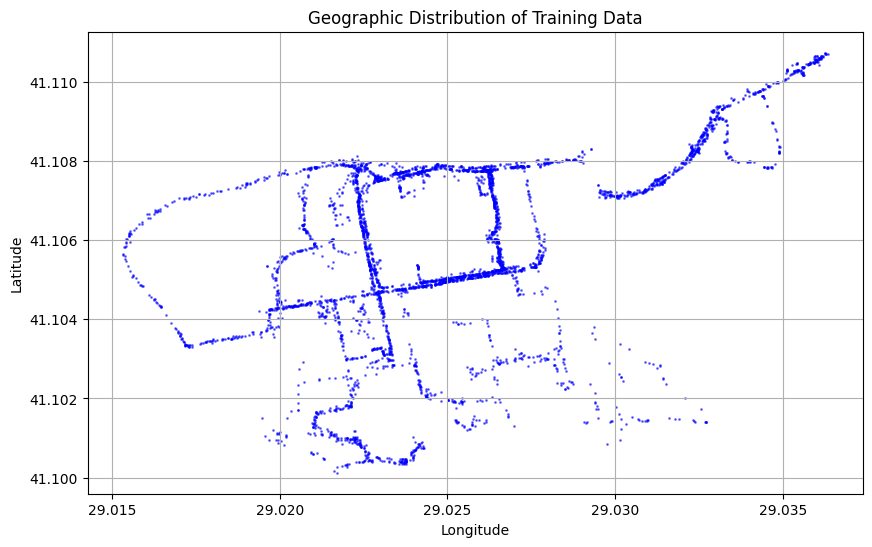

In [39]:
# ====================
# Data Visualization
# ====================

def visualize_coordinates(train_data):
    """Simple visualization of geographic distribution"""
    plt.figure(figsize=(10, 6))
    plt.scatter(train_data['longitude'], train_data['latitude'], 
                alpha=0.5, s=1, c='blue')
    plt.title('Geographic Distribution of Training Data')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

# Load and prepare data
train_data = pd.read_csv(TRAIN_CSV, sep=';')

# Visualize the geographic distribution
visualize_coordinates(train_data)

# Get coordinate ranges for normalization
lat_min, lat_max = train_data['latitude'].min(), train_data['latitude'].max()
long_min, long_max = train_data['longitude'].min(), train_data['longitude'].max()

In [40]:
# ====================
# Data Transformations
# ====================

# Training data transformations with augmentation
train_transforms = transforms.Compose([
    transforms.RandomGrayscale(p=0.20),
    transforms.RandomPosterize(5,p=0.5),
    transforms.RandomEqualize(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.ColorJitter(brightness=0.20, contrast=0.20, saturation=0.20, hue=0.10),
    transforms.ToTensor()
])

# Validation/Test data transformations (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [41]:
# ====================
# Dataset Class
# ====================

class StreetViewDataset(Dataset):
    """
    Custom Dataset class for street view images with location data
    """
    def __init__(self, csv_file, img_dir, transform=None, is_test=False):
        """
        Args:
            csv_file (str): Path to the CSV file with annotations
            img_dir (str): Directory with all the images
            transform (callable, optional): Optional transform to be applied on a sample
            is_test (bool): Whether this is test dataset
        """
        if is_test:
            self.df = pd.read_csv(csv_file, sep=';')
        else:
            self.df = pd.read_csv(csv_file)
        
        self.img_dir = img_dir
        self.transform = transform
        self.blur = transforms.GaussianBlur((3,3), sigma=(0.1, 2.0))
        self.is_test = is_test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, row_index):
        # Get image filename and path
        row = self.df.iloc[row_index]
        filename = row['filename']
        img_path = os.path.join(self.img_dir, filename)
        
        # Load and process image
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found at path: {img_path}")
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        # Random blur augmentation
        if random.randint(0,10) > 5:
            self.blur(image)
        
        # Handle test vs train data
        if self.is_test:
            return image, filename
        
        # Extract and validate coordinates
        long = row.get('longitude', None)
        lat = row.get('latitude', None)
        
        if long is None or lat is None:
            raise ValueError(f"Coordinates missing for row: {row_index}")
        
        return image, torch.tensor([lat, long], dtype=torch.float32)

In [42]:
# ====================
# Model Architecture
# ====================

class CustomCNN(nn.Module):
    """
    Custom CNN model based on EfficientNet-B2 for location prediction
    """
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Load pre-trained EfficientNet
        self.model = models.efficientnet_b2(models.EfficientNet_B2_Weights.DEFAULT)
        self.out_features = self.model.classifier[1].in_features
        
        # Custom classifier head
        self.model.classifier[1] = nn.Sequential(
            # First dense block
            nn.Linear(self.out_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.20),
            
            # Second dense block
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.20),
            
            # Output layer for lat/long prediction
            nn.Linear(256, 2)
        )
    
    def forward(self, images):
        return self.model(images)

In [43]:
# ====================
# Distance Calculations
# ====================

def haversine_distance(pred_coords, true_coords):
    """
    Calculate the Haversine distance between predicted and true coordinates
    Args:
        pred_coords: Predicted coordinates (normalized)
        true_coords: True coordinates (normalized)
    Returns:
        Distances in kilometers
    """
    # Denormalize coordinates
    pred_coords = [[val[0] * (lat_max - lat_min) + lat_min, 
                   val[1] * (long_max - long_min) + long_min] for val in pred_coords]
    true_coords = [[val[0] * (lat_max - lat_min) + lat_min, 
                   val[1] * (long_max - long_min) + long_min] for val in true_coords]
    
    pred_coords = torch.tensor(pred_coords, dtype=torch.float32)
    true_coords = torch.tensor(true_coords, dtype=torch.float32)

    # Convert to radians
    pred_coords_rad = torch.deg2rad(pred_coords)
    true_coords_rad = torch.deg2rad(true_coords)

    lat1, lon1 = pred_coords_rad[:, 0], pred_coords_rad[:, 1]
    lat2, lon2 = true_coords_rad[:, 0], true_coords_rad[:, 1]

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = torch.sin(dlat / 2)**2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2)**2
    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
    
    # Earth's radius in kilometers
    R = 6371.0
    return R * c

def haversine_rmse(pred_coords, true_coords):
    """Calculate RMSE based on Haversine distances"""
    distances = haversine_distance(pred_coords, true_coords)
    return torch.sqrt(torch.mean(distances**2))

In [44]:
# ====================
# Training Functions
# ====================

def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for images, labels in loader:
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Record results
        running_loss += loss.item() * images.size(0)
        all_preds.extend(outputs.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
    
    # Calculate epoch metrics
    epoch_loss = running_loss / len(loader.dataset)
    epoch_rms = haversine_rmse(all_preds, all_labels)
    
    return epoch_loss, epoch_rms

def validate_one_epoch(model, loader, criterion, device):
    """Validate the model for one epoch"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Record results
            running_loss += loss.item() * images.size(0)
            all_preds.extend(outputs.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
    
    # Calculate epoch metrics
    epoch_loss = running_loss / len(loader.dataset)
    epoch_rms = haversine_rmse(all_preds, all_labels)
    
    return epoch_loss, epoch_rms

In [45]:
# ====================
# Main Training Loop
# ====================

# Load and prepare data
train_data = pd.read_csv(TRAIN_CSV, sep=';')

# Get coordinate ranges for normalization
lat_min, lat_max = train_data['latitude'].min(), train_data['latitude'].max()
long_min, long_max = train_data['longitude'].min(), train_data['longitude'].max()

# Normalize coordinates
train_data['latitude'] = (train_data['latitude'] - lat_min) / (lat_max - lat_min)
train_data['longitude'] = (train_data['longitude'] - long_min) / (long_max - long_min)

# Split data into train and validation sets
df_train_all = train_data.sample(frac=1).reset_index(drop=True)
val_ratio = 0.12
val_size = int(len(df_train_all) * val_ratio)
train_size = len(df_train_all) - val_size

df_train = df_train_all.iloc[:train_size]
df_val = df_train_all.iloc[val_size:]

# Save temporary CSV files
df_train.to_csv("temp_train.csv", index=False)
df_val.to_csv("temp_val.csv", index=False)

# Create data loaders
train_dataset = StreetViewDataset("temp_train.csv", TRAIN_DIR, transform=train_transforms)
val_dataset = StreetViewDataset("temp_val.csv", TRAIN_DIR, transform=val_test_transforms)
test_dataset = StreetViewDataset(TEST_CSV, TEST_DIR, transform=val_test_transforms, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize model and training components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_custom = CustomCNN().to(device)
model_custom_opt = optim.AdamW(model_custom.parameters(), lr=learning_rate, weight_decay=1e-6)
criterion = nn.SmoothL1Loss(beta=1)
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(
    model_custom_opt, mode='min', factor=0.5, patience=3, verbose=True
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [46]:
# Training loop
best_rms = float("inf")
patience = 10
current_patience = 0

for epoch in range(1, num_epochs + 1):
    # Time tracking
    start_time = time.time()
    
    # Training phase
    train_loss, train_rms = train_one_epoch(model_custom, train_loader, criterion, model_custom_opt, device)
    
    # Validation phase
    val_loss, val_rms = validate_one_epoch(model_custom, val_loader, criterion, device)
    
    # Print epoch results
    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch}/{num_epochs}] --- Time: {epoch_time:.2f} seconds")
    print(f"  Loss Train: {train_loss:.5f} --- Loss Val: {val_loss:.5f}")
    print(f"  RMS  Train: {train_rms:.5f} --- RMS  Val: {val_rms:.5f}")
    
    # Model checkpoint saving
    if val_rms < best_rms:
        current_patience = 0
        best_rms = val_rms
        torch.save(model_custom.state_dict(), "/kaggle/working/custom_model.pth")
        print(">>> Model improved and saved!")
    else:
        current_patience += 1
        
    # Learning rate adjustment
    scheduler_lr.step(val_rms)

print("Training complete! Best Validation RMS:", best_rms)


Epoch [1/10] --- Time: 51.56 seconds
  Loss Train: 0.27723 --- Loss Val: 0.19067
  RMS  Train: 1.60878 --- RMS  Val: 1.22076
>>> Model improved and saved!
Epoch [2/10] --- Time: 50.86 seconds
  Loss Train: 0.21486 --- Loss Val: 0.17241
  RMS  Train: 1.39601 --- RMS  Val: 1.21078
>>> Model improved and saved!
Epoch [3/10] --- Time: 51.61 seconds
  Loss Train: 0.18476 --- Loss Val: 0.15119
  RMS  Train: 1.28712 --- RMS  Val: 1.12066
>>> Model improved and saved!
Epoch [4/10] --- Time: 50.12 seconds
  Loss Train: 0.16253 --- Loss Val: 0.12077
  RMS  Train: 1.20502 --- RMS  Val: 0.99477
>>> Model improved and saved!
Epoch [5/10] --- Time: 48.95 seconds
  Loss Train: 0.14336 --- Loss Val: 0.11130
  RMS  Train: 1.12805 --- RMS  Val: 0.97651
>>> Model improved and saved!
Epoch [6/10] --- Time: 49.78 seconds
  Loss Train: 0.12797 --- Loss Val: 0.08456
  RMS  Train: 1.06260 --- RMS  Val: 0.85442
>>> Model improved and saved!
Epoch [7/10] --- Time: 49.36 seconds
  Loss Train: 0.11272 --- Loss Va

In [47]:
# ====================
# Prediction Phase
# ====================

# Load best model
model_custom.load_state_dict(torch.load("/kaggle/working/custom_model.pth", weights_only=True))
model_custom.eval()

# Prepare prediction lists
pred_filenames = []
pred_latitudes = []
pred_longitudes = []

# Generate predictions
with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model_custom(images).cpu().numpy()
        
        for i, fname in enumerate(filenames):
            pred_filenames.append(fname)
            pred_latitudes.append(outputs[i][0])
            pred_longitudes.append(outputs[i][1])

# Denormalize predictions
pred_latitudes = np.array(pred_latitudes) * (lat_max - lat_min) + lat_min 
pred_longitudes = np.array(pred_longitudes) * (long_max - long_min) + long_min

# Create and save submission file
submission_df = pd.DataFrame({
    "filename": pred_filenames,
    "latitude": pred_latitudes,
    "longitude": pred_longitudes
})
submission_df.to_csv("/kaggle/working/submission.csv", index=False)
print("Submission file has been created successfully!")

Submission file has been created successfully!
